In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("~/Vault/Thesis/Data/pm25_weer.csv")
data

,id,no2,pm10,pm10_cal,pm10_fac,pm10_max,pm10_min,pm25,pm25_cal,pm25_fac,...,YYYYMMDD,jaar,maand,weeknummer,dag,H,T,U,DD,FH
0,1,NaN,8.195,8.774,1.070000,8.39,8.00,4.000,1.640,0.410000,...,20190712,2019,7,28,12,14,173,86,320,60
1,4,NaN,17.258,18.165,1.052000,20.10,15.60,11.176,4.256,0.381000,...,20190712,2019,7,28,12,14,173,86,320,60
2,5,NaN,19.952,20.497,1.027000,24.40,16.50,10.810,3.996,0.370000,...,20190712,2019,7,28,12,14,173,86,320,60
3,7,NaN,20.278,21.216,1.042000,24.40,16.20,11.510,4.292,0.371000,...,20190712,2019,7,28,12,14,173,86,320,60
4,10,NaN,18.099,19.186,1.062000,21.90,14.70,8.942,3.471,0.390000,...,20190712,2019,7,28,12,14,173,86,320,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349808,199,33.4319,24.660,16.796,0.681103,28.50,20.50,11.910,9.877,0.829303,...,20221022,2022,10,42,22,23,127,92,140,20
1349809,200,43.1974,0.000,0.000,NaN,0.00,0.00,0.000,0.000,NaN,...,20221022,2022,10,42,22,23,127,92,140,20
1349810,212,2.5000,23.074,22.407,0.971261,29.30,18.29,7.887,11.534,1.461850,...,20221022,2022,10,42,22,23,127,92,140,20
1349811,213,39.1156,37.694,36.569,0.970257,60.80,24.40,9.182,13.432,1.463180,...,20221022,2022,10,42,22,23,127,92,140,20


In [3]:
data.columns

Index(['id', 'no2', 'pm10', 'pm10_cal', 'pm10_fac', 'pm10_max', 'pm10_min',
       'pm25', 'pm25_cal', 'pm25_fac', 'pm25_max', 'pm25_min', 'timestamp',
       'components', 'latitude', 'longitude', 'name', 'sensortype', 'tag',
       'datum', 'tijd', 'weekdag', 'uur', '#STN', 'YYYYMMDD', 'jaar', 'maand',
       'weeknummer', 'dag', 'H', 'T', 'U', 'DD', 'FH'],
      dtype='object')

In [4]:
data.drop(data.iloc[:, 0:7], axis=1, inplace=True)
data.drop(["jaar", "maand", "weeknummer", "#STN", "timestamp", "components", "dag", "tijd", "datum", "H"], axis=1, inplace=True)
data

,pm25,pm25_cal,pm25_fac,pm25_max,pm25_min,latitude,longitude,name,sensortype,tag,weekdag,uur,YYYYMMDD,T,U,DD,FH
0,4.000,1.640,0.410000,4.1,3.9,52.472796,4.662902,Zuiderkade,holu,Beverwijk,4,14,20190712,173,86,320,60
1,11.176,4.256,0.381000,12.4,10.1,52.490108,4.657723,Grote Houtweg,holu,Beverwijk,4,14,20190712,173,86,320,60
2,10.810,3.996,0.370000,12.3,9.0,52.484320,4.642918,Westerhoutplein,holu,Beverwijk,4,14,20190712,173,86,320,60
3,11.510,4.292,0.371000,13.9,10.0,52.487020,4.650807,Beukenstraat,holu,Beverwijk,4,14,20190712,173,86,320,60
4,8.942,3.471,0.390000,10.3,7.3,52.477398,4.658354,Parallelweg,holu,Beverwijk,4,14,20190712,173,86,320,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349808,11.910,9.877,0.829303,15.2,10.3,52.473001,4.662653,Zuiderkade,holu-extended,Beverwijk,5,23,20221022,127,92,140,20
1349809,0.000,0.000,NaN,0.0,0.0,52.477803,4.654015,Stationsplein,holu-extended,Beverwijk,5,23,20221022,127,92,140,20
1349810,7.887,11.534,1.461850,8.7,7.2,52.458385,4.834105,Fluitekruidweg,holu-extended,Zaandam,5,23,20221022,127,92,140,20
1349811,9.182,13.432,1.463180,10.5,8.3,52.458385,4.834105,Fluitekruidweg,holu-extended,Zaandam,5,23,20221022,127,92,140,20


In [5]:
data = data[data.pm25 != 0]
data = data.dropna()
data

,pm25,pm25_cal,pm25_fac,pm25_max,pm25_min,latitude,longitude,name,sensortype,tag,weekdag,uur,YYYYMMDD,T,U,DD,FH
0,4.000,1.640,0.410000,4.1,3.9,52.472796,4.662902,Zuiderkade,holu,Beverwijk,4,14,20190712,173,86,320,60
1,11.176,4.256,0.381000,12.4,10.1,52.490108,4.657723,Grote Houtweg,holu,Beverwijk,4,14,20190712,173,86,320,60
2,10.810,3.996,0.370000,12.3,9.0,52.484320,4.642918,Westerhoutplein,holu,Beverwijk,4,14,20190712,173,86,320,60
3,11.510,4.292,0.371000,13.9,10.0,52.487020,4.650807,Beukenstraat,holu,Beverwijk,4,14,20190712,173,86,320,60
4,8.942,3.471,0.390000,10.3,7.3,52.477398,4.658354,Parallelweg,holu,Beverwijk,4,14,20190712,173,86,320,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349807,3.815,3.306,0.865445,6.6,2.7,52.493494,4.690449,Schutterskwartier,holu-extended,Heemskerk,5,23,20221022,127,92,140,20
1349808,11.910,9.877,0.829303,15.2,10.3,52.473001,4.662653,Zuiderkade,holu-extended,Beverwijk,5,23,20221022,127,92,140,20
1349810,7.887,11.534,1.461850,8.7,7.2,52.458385,4.834105,Fluitekruidweg,holu-extended,Zaandam,5,23,20221022,127,92,140,20
1349811,9.182,13.432,1.463180,10.5,8.3,52.458385,4.834105,Fluitekruidweg,holu-extended,Zaandam,5,23,20221022,127,92,140,20


In [6]:
for i in range(7, len(data.columns)):
    print(f'{data.iloc[:, i].unique()}\n')

['Zuiderkade' 'Grote Houtweg' 'Westerhoutplein' 'Beukenstraat'
 'Parallelweg' 'Toon Hermanslaan' 'Lange acker' 'Schutterskwartier'
 'Baanstraat' 'Wijk aan Duinerweg' 'Jan Pleeginghof' 'Drechtstraat'
 'Duinvlietstraat' 'Creutzberglaan' 'Neeltje Snijdershof'
 'Louis Davidslaan' 'Relweg' 'Nachtegaallaan' 'Julianaweg'
 'Herman Gorterpad' 'Driehuizerkerkweg' 'Vondelpark' 'Kees Delfsweg'
 'Vlaanderenstraat' 'Verlengde Voorstraat' 'Paulus Potterstraat'
 'Velserduinweg' 'Fazantenlaan' 'Hortensiastraat' 'Kogeldistelstraat'
 'Zuiderzeepark' 'Papaverweg' 'De Nollen' 'Doctor Schuitstraat'
 'Kleine Pan' 'Hondemanstraat' 'Slachthuisstraat' 'Fluitekruidweg'
 'Fultonstraat' 'Ridderspoorweg' 'Duinweg' 'Klaprozenweg' 'Badhuiskade'
 'Albatrospad' 'Hulstweg' 'Oostzijde' 'Burgemeester Rothestraat'
 'Perzikkruidweg' 'Varenweg' 'Christoffelkruidstraat' 'Zeestraat'
 'Wijkerstraatweg' 'Hoflanderweg' 'Büllerlaan' 'Monnikskapstraat'
 'Raadhuisstraat' 'Stationsweg' 'Beeckzanglaan' 'Willebrordstraat'
 'Haagdoornho

In [7]:
data.describe()

,pm25,pm25_cal,pm25_fac,pm25_max,pm25_min,latitude,longitude,weekdag,uur,YYYYMMDD,T,U,DD,FH
count,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06,1.299702e+06
mean,1.994978e+01,2.317306e+01,1.274092e+00,2.293767e+01,1.773147e+01,5.245566e+01,4.728854e+00,2.994806e+00,1.171020e+01,2.020897e+07,1.150777e+02,7.721990e+01,1.949082e+02,4.833851e+01
std,5.448820e+01,7.930986e+01,5.626330e-01,5.799681e+01,5.304337e+01,4.626443e-02,1.177825e-01,1.988095e+00,6.820135e+00,9.194416e+03,6.315669e+01,1.515891e+01,1.211502e+02,2.773193e+01
min,5.000000e-03,0.000000e+00,0.000000e+00,1.000000e-01,0.000000e+00,5.223809e+01,4.587601e+00,0.000000e+00,0.000000e+00,2.019062e+07,-9.700000e+01,2.200000e+01,0.000000e+00,0.000000e+00
25%,2.890000e+00,4.032000e+00,8.700000e-01,3.800000e+00,2.090000e+00,5.244311e+01,4.638830e+00,1.000000e+00,6.000000e+00,2.020071e+07,6.700000e+01,6.800000e+01,1.100000e+02,3.000000e+01
50%,6.162000e+00,7.564000e+00,1.194130e+00,7.700000e+00,4.900000e+00,5.246332e+01,4.662902e+00,3.000000e+00,1.200000e+01,2.021050e+07,1.110000e+02,8.000000e+01,2.000000e+02,4.000000e+01
75%,1.510000e+01,1.494600e+01,1.599810e+00,1.840000e+01,1.250000e+01,5.249211e+01,4.834105e+00,5.000000e+00,1.800000e+01,2.022013e+07,1.620000e+02,8.900000e+01,2.700000e+02,6.000000e+01
max,6.405900e+02,1.539910e+03,7.980000e+00,6.553000e+02,6.405900e+02,5.252332e+01,4.955276e+00,6.000000e+00,2.300000e+01,2.022102e+07,3.610000e+02,1.000000e+02,9.900000e+02,2.300000e+02


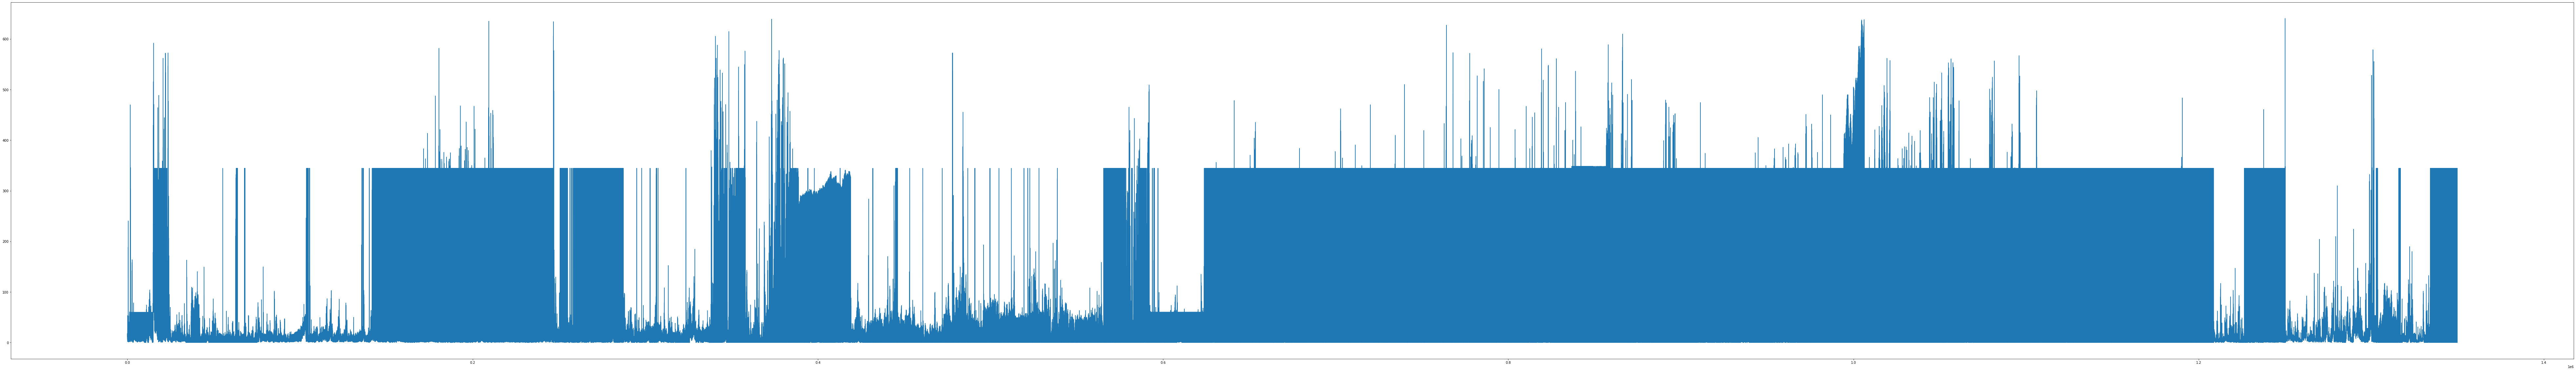

In [8]:
plt.figure(figsize=(140, 20))
plt.plot(data["pm25"])
plt.show()

In [9]:
Beverwijk = data[data.tag == "Beverwijk"].copy()
Beverwijk = Beverwijk[Beverwijk.pm25 < 200]
Beverwijk = Beverwijk[Beverwijk.pm25_cal < 200].reset_index()
del Beverwijk["index"]
Beverwijk

,pm25,pm25_cal,pm25_fac,pm25_max,pm25_min,latitude,longitude,name,sensortype,tag,weekdag,uur,YYYYMMDD,T,U,DD,FH
0,4.000,1.640,0.410000,4.1,3.9,52.472796,4.662902,Zuiderkade,holu,Beverwijk,4,14,20190712,173,86,320,60
1,11.176,4.256,0.381000,12.4,10.1,52.490108,4.657723,Grote Houtweg,holu,Beverwijk,4,14,20190712,173,86,320,60
2,10.810,3.996,0.370000,12.3,9.0,52.484320,4.642918,Westerhoutplein,holu,Beverwijk,4,14,20190712,173,86,320,60
3,11.510,4.292,0.371000,13.9,10.0,52.487020,4.650807,Beukenstraat,holu,Beverwijk,4,14,20190712,173,86,320,60
4,8.942,3.471,0.390000,10.3,7.3,52.477398,4.658354,Parallelweg,holu,Beverwijk,4,14,20190712,173,86,320,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287557,13.408,11.256,0.839374,15.2,11.7,52.491220,4.645448,Haagdoornhof,holu,Beverwijk,5,23,20221022,127,92,140,20
287558,11.985,10.080,0.840701,13.9,10.0,52.496264,4.663141,President Kennedyplein,holu,Beverwijk,5,23,20221022,127,92,140,20
287559,0.388,0.340,0.871795,2.3,0.1,52.492110,4.668939,Hoflanderweg,holu,Beverwijk,5,23,20221022,127,92,140,20
287560,0.133,0.086,0.661538,0.6,0.1,52.486012,4.679110,Toon Hermanslaan,holu-extended,Beverwijk,5,23,20221022,127,92,140,20


In [10]:
array = Beverwijk["pm25"].to_numpy()

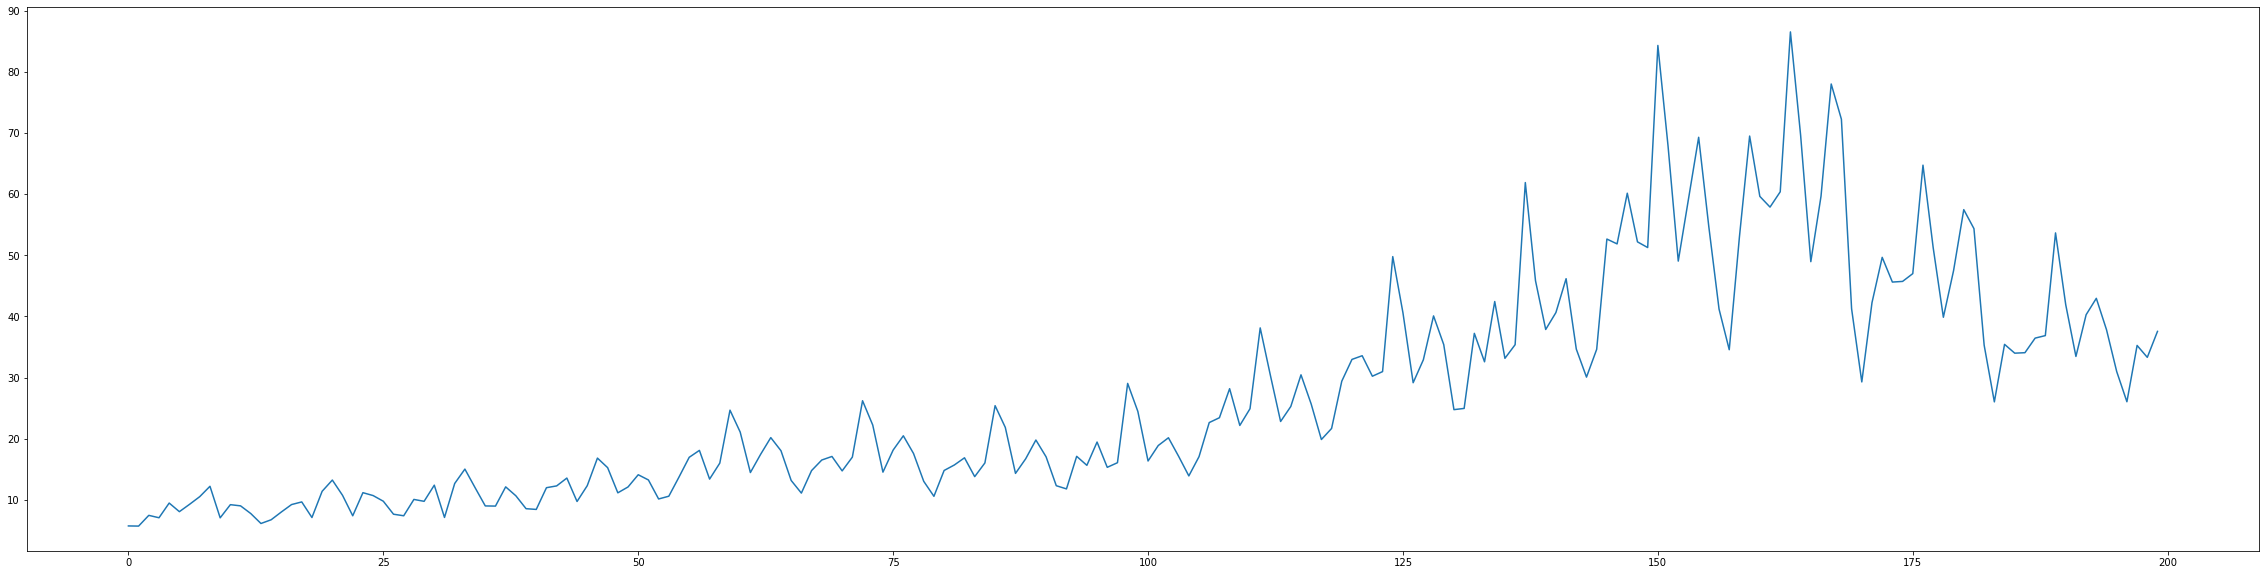

In [15]:
plt.figure(figsize=(40, 10))
plt.plot(array[12800:13000])
plt.show()